In [ ]:
---
title: Bickley Jet Distributed Demo
author: JSP
date: 12/28/2022
format:
  html:
    code-fold: true
---

## TEST BiCKLEY JET DISTRIBUTED


  Activating project at `~/JULIA/CoherentStructures.jl`


┌ Info: Found 63 singularities...
└ @ CoherentStructures /Users/julios/JULIA/CoherentStructures.jl/src/ellipticLCS.jl:894
┌ Info: Defined 7 Poincaré sections...
└ @ CoherentStructures /Users/julios/JULIA/CoherentStructures.jl/src/ellipticLCS.jl:896


Detecting vortices  29%|█████████▍                       |  ETA: 0:00:21


Detecting vortices 100%|█████████████████████████████████| Time: 0:00:11
  num_barriers:  7


┌ Info: Found 7 elliptic barriers in total.
└ @ CoherentStructures /Users/julios/JULIA/CoherentStructures.jl/src/ellipticLCS.jl:1194


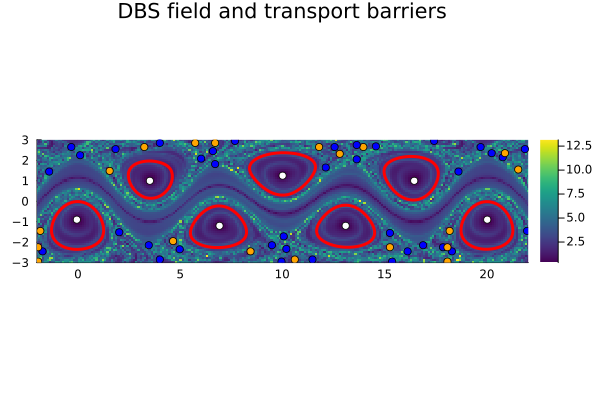

In [3]:
#| label: fig-streamplot
#| fig-cap: Stream Plot

#using Distributed
#nprocs() == 1 && addprocs()
#@everywhere begin
      import Pkg
         Pkg.activate("/Users/julios/JULIA/CoherentStructures.jl/")
      #end

#@everywhere 
using CoherentStructures, StreamMacros
const bickley = @velo_from_stream psi begin
    psi  = psi₀ + psi₁
    psi₀ = - U₀ * L₀ * tanh(y / L₀)
    psi₁ =   U₀ * L₀ * sech(y / L₀)^2 * re_sum_term

    re_sum_term = Σ₁ + Σ₂ + Σ₃

    Σ₁ = ε₁ * cos(k₁*(x - c₁*t))
    Σ₂ = ε₂ * cos(k₂*(x - c₂*t))
    Σ₃ = ε₃ * cos(k₃*(x - c₃*t))

    k₁ = 2/r₀    ; k₂ = 4/r₀   ; k₃ = 6/r₀
    ε₁ = 0.0075  ; ε₂ = 0.15   ; ε₃ = 0.3
    c₂ = 0.205U₀ ; c₃ = 0.461U₀; c₁ = c₃ + (√5-1)*(c₂-c₃)
    U₀ = 62.66e-6; L₀ = 1770e-3; r₀ = 6371e-3
end

#@everywhere 
using OrdinaryDiffEq, Tensors
q = 81
const tspan = range(0., stop=3456000., length=q)
ny = 61
nx = (22ny) ÷ 6
xmin, xmax, ymin, ymax = 0.0 - 2.0, 6.371π + 2.0, -3.0, 3.0
xspan = range(xmin, stop=xmax, length=nx)
yspan = range(ymin, stop=ymax, length=ny)
P = tuple.(xspan, yspan')
const δ = 1.e-6
const D = SymmetricTensor{2,2}((2., 0., 1/2))
mCG_tensor = u -> av_weighted_CG_tensor(bickley, u, tspan, δ; D=(_ -> D), tolerance=1e-6, solver=Tsit5())

#C̅ = pmap(mCG_tensor, P; batch_size=ceil(Int, length(P)/nprocs()^2))
C̅ = map(mCG_tensor, P)
p = LCSParameters(2.0)
vortices, singularities = ellipticLCS(C̅, xspan, yspan, p)

using Plots
trace = tensor_invariants(C̅)[5]
fig = plot_vortices(vortices, singularities, (xmin, ymin), (xmax, ymax);
    bg=trace, xspan=xspan, yspan=yspan, title="DBS field and transport barriers", showlabel=false)
Plots.plot(fig)